In [ ]:
#Uncomment if you're using colab
#Setting up google drive 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')

In [ ]:
%matplotlib inline
import my_utils as mu
import torch
import torch.nn as nn
from torch.utils import data

# The Task

* Our **Task** for this week is to apply Linear Regression to Sequential Data; in particular to time series. The model that we will develop is a simple *Auto-Regressive* Model which is an widely-used family of models in Machine Learning. 
* The Learning Outcome: Hands-on application of PyTorch's API for solving Linear Regression.


# Data Generation

* We generate our sequence data by using a function $x = f(t)$ with some additive noise for time steps $1, 2, \ldots, 1000$.
* We define the function $f(.)$ as follows:

In [3]:
def f(time):
    return torch.sin(0.1 * time) * torch.exp(-0.001*time)# + torch.normal(0, 0.2, (T,))

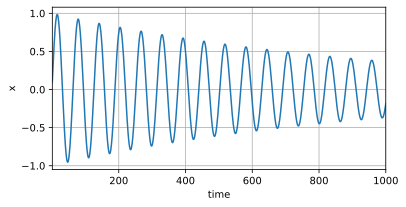

In [4]:
# Run the following code
T = 1000  # Generate a total of 1000 points
time = torch.arange(1, T + 1, dtype=torch.float32)
x = f(time)
# Uncomment line below for Task 6
#x = 1.0/ (1.0 + f(time))
mu.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

## Question
* Do you expect that a linear model can approximately well the above function?

## Task 1
* Your first task is to turn the above sequence into features and labels that we can train our model on.
* You should create your dataset as follows: for every time instance $t$, the target (i.e. ground truth label) will be $y_t = x_t$ and the input features $\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$. 
    * Choose $\tau=4$ and start from $t=\tau+1$. So the first (input features, target) pair should be $([x_0, x_1, x_2, x_3], x_4)$, the second $([x_1, x_2, x_3, x_4], x_5)$ and so on.
* Store the features in a matrix (using a tensor from `torch`) called `features` so that the first row contains the first input feature, the second row the second input feature and so on. For example `features[0, :]= x_0, x_1, x_2, x_3`.
*  Store the labels in a vector (using a tensor from `torch`) called `labels` so that the first element contains the first target, the second row the second label and so on.  


In [5]:
# Write your code here to create the two tensors: features and labels
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = mu.reshape(x[tau:], (-1, 1)) 

In [ ]:
# Might be good idea to check here that the features and labels tensors contain the right data 
# by printing the values they contain. What are their dimensions?
print(features.shape)
print(labels.shape)
print(x[:7])
print(features[0:3])
print(labels[0:3])

# Task 2
* Use `data.TensorDataset` and the previously created matrices to create your dataset. Simply call it `dataset`. 
    * Use the first 600 feature-label pairs for training.
    * Check lecture slides and `torch` documentation if necessary.
* Use `data.DataLoader` to create your dataloader. Pick a reasonable value for the batch size (e.g. `batch_size=16`).
    * You can call your dataloader `data_iter`

In [7]:
# Write your code here to create dataset and data_iter
n_train = 600 # number of feature-labels pairs used for training
dataset = data.TensorDataset(features[:n_train], labels[:n_train]) #TensorDataset object
print(dataset[0]) #First example in our dataset
batch_size = 16
data_iter =  data.DataLoader(dataset, batch_size, shuffle=True) #DataLoader object


(tensor([0.0997, 0.1983, 0.2946, 0.3879]), tensor([0.4770]))


# Task 3
* This task is about creating, initializing and training a linear net, using PyTorch's API. You have to implement the following 4 steps: 
    1. Create a simple linear net and initialize it appropriately.
    1. Use an MSE loss.
    1. From `torch.optim` use Adam to create an `optimizer`.
    1. Write a training function with the following signature `train(net, data_iter, loss, optimizer, epochs)` and use it to train your network.

In [8]:
# Write code for defining and initializing your model here
num_of_inp, num_of_out = 4, 1 # input, output feature dimension

net = nn.Linear(num_of_inp, num_of_out)
net.weight.data.normal_(0, 0.01); # each weight sampled from a Gaussian with mean 0 and std 0.01.
net.bias.data.fill_(0);

In [9]:
# Write code for creating the loss and the optimizer here
loss = nn.MSELoss()
lr = 0.01
optimizer = torch.optim.SGD(net.parameters(), lr)

In [10]:
# Write code for the training function train(net, data_iter, loss, optimizer, epochs) here
def train(net, train_iter, loss, optimizer, epochs):
    for epoch in range(epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
            print(f'epoch {epoch + 1}, 'f'loss: {mu.evaluate_loss(net, train_iter, loss):f}')

In [ ]:
# Write code for training the model here. This refers to calling the train function.
train(net, data_iter, loss, optimizer, 400)

## Task 4 

* Use the model to *predict* what happens in the next time step. 
    * This is called *one-step-ahead prediction*.
    * Store the ouput of your model in a variable call `onestep_preds` and use the following code to plot the original data and the model's prediction.
    * What do you oberve? Can the model predict the output samples correctly? Can you explain why?

In [12]:
# Write code for getting the model's predictions onestep_preds here
onestep_preds = net(features)

In [ ]:
# this will not work if the you don't provide onestep_preds :)
mu.plot([time, time[tau:]], [mu.numpy(x), mu.numpy(onestep_preds)], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

## Task 5
* Modify the above code to plot the absolute difference between tha data and the model's prediction.

In [ ]:
# Write the modified plot function here
mu.plot(time[tau:], mu.numpy((x[tau:]-onestep_preds.squeeze(1)).abs()) , 'time',
        'x', legend=['error'], xlim=[1, 1000],
         figsize=(6, 3))

## Task 6

* Change the generating function to $x = \frac{1.0}{1.0 + f(t)}$ and repeat the above mentioned steps.
* What do you observe? 


## Task 7 -- Optional

* Re-run your code with the original generating function to $x = f(t)$.
* It turns out that our previous predictions were too good to be true. The reason for this is that after we train the model using the first let's say 600 samples we cannot expect to have the inputs for all one-step-ahead predictions beyond this point.

* Instead, we need to work our way forward one step at a time:

$$
\hat{x}_{605} = f(x_{601}, x_{602}, x_{603}, x_{604}), \\
\hat{x}_{606} = f(x_{602}, x_{603}, x_{604}, \hat{x}_{605}), \\
\hat{x}_{607} = f(x_{603}, x_{604}, \hat{x}_{605}, \hat{x}_{606}),\\
\hat{x}_{608} = f(x_{604}, \hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}),\\
\hat{x}_{609} = f(\hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}, \hat{x}_{608}),\\
\ldots
$$

* In other words, we will have to use our own predictions to make multistep-ahead predictions.
* You are tasked to write some code to be able to do this. Store the model's prediction in variable called `multistep_preds`.

In [17]:
# Write the code to obtain the multistep-ahead predictions (multistep_preds) 
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = mu.reshape(net(multistep_preds[i - tau: i].reshape(1, -1)), 1)

## Task 8 -- Optional
* Modify the plotting code above to plot the original data, the one step predictions from Task 4 (`onestep_preds`) along with the multistep-ahead predictions from Task 7.
* What do you observe? Do you have some explanation for what happens?

In [ ]:
mu.plot([time, time[tau:], time[n_train + tau:]],
         [mu.numpy(x), mu.numpy(onestep_preds),
          mu.numpy(multistep_preds[n_train + tau:])], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

# Answer

* Why did the algorithm work so poorly?
* This is ultimately due to the fact that the errors build up. Let us say that after step 1 we have some error $\epsilon_1 = \bar\epsilon$. Now the *input* for step 2 is perturbed by $\epsilon_1$, hence we suffer some error in the order of $\epsilon_2 = \bar\epsilon + c \epsilon_1$ for some constant $c$, and so on. The error can diverge rather rapidly from the true observations. 